In [7]:
import sys, os
import pickle
sys.path.append('..')
sys.path.append('../..')

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from scipy.stats import t 
from itertools import product
import pystan

from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       make_stan_log_density, 
                       adagrad_optimize)
from experiments import *

sns.set_style('white')
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2})

In [9]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [10]:
def plot_sample_contours(x_samples1, y_samples1, x_samples2, y_samples2, xlabel, ylabel, xlim, ylim, 
                    cmap1, cmap2, savepath=None, **kwargs):
    sns.kdeplot(x_samples1, y_samples1, cmap=cmap1, **kwargs)
    sns.kdeplot(x_samples2, y_samples2, cmap=cmap2, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def plot_sample_and_density_contours(x_samples, y_samples, logdensity, xlabel, ylabel, xlim, ylim, 
                    cmap_samples, cmap_density, savepath=None, **kwargs):
    sns.kdeplot(x_samples, y_samples, cmap=cmap_samples, **kwargs)
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    Z = np.exp(logdensity(XY))
    plt.contour(X, Y, Z, cmap=cmap_density, linestyles='solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def tranform_to_theta(ncp_samples):
    ncp_samples_tranformed = ncp_samples.copy()
    ncp_samples_tranformed[2:] = (ncp_samples_tranformed[0] 
                                  + np.exp(ncp_samples_tranformed[1]) * ncp_samples_tranformed[2:])
    return ncp_samples_tranformed

def get_ncp_approx_samples(var_family, opt_param, n_samples):
    ncp_samples = var_family.sample(opt_param, n_samples).T
    return ncp_samples, tranform_to_theta(ncp_samples)

In [11]:
try:
    cp = pickle.load(open('eight_schools_cp.pkl', 'rb'))
except:
    cp = pystan.StanModel(file='eight_schools_cp.stan', model_name='eight_School_cp_model')
    with open('eight_schools_cp.pkl', 'wb') as f:
        pickle.dump(cp, f)

In [12]:
try:
    ncp = pickle.load(open('eight_schools_ncp.pkl', 'rb'))
except:
    ncp = pystan.StanModel(file='eight_schools_ncp.stan', model_name='eight_School_ncp_model')
    with open('eight_schools_ncp.pkl', 'wb') as f:
        pickle.dump(ncp, f)

In [13]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [14]:
eight_schools_cp_fit = cp.sampling(data=data, iter=11000, warmup=1000,
                                                            control=dict(adapt_delta=.99))

In [15]:
eight_schools_ncp_fit = ncp.sampling(data=data, iter=32000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [16]:
eight_schools_ncp_fit

Inference for Stan model: eight_School_model_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=32000; warmup=2000; thin=3; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                4.4    0.02   3.31  -2.15    2.2   4.41   6.63  10.87  39436    1.0
tau               3.6    0.02    3.2   0.12   1.27   2.75   5.01  11.83  38835    1.0
theta_tilde[1]   0.32  5.0e-3    1.0  -1.69  -0.35   0.33   0.99   2.24  40044    1.0
theta_tilde[2]    0.1  4.7e-3   0.93  -1.78  -0.52   0.11   0.72   1.93  40143    1.0
theta_tilde[3]  -0.08  4.9e-3   0.97  -1.97  -0.73  -0.09   0.56   1.84  39715    1.0
theta_tilde[4]   0.06  4.8e-3   0.95   -1.8  -0.57   0.07    0.7    1.9  39215    1.0
theta_tilde[5]  -0.17  4.7e-3   0.93   -2.0  -0.79  -0.17   0.45   1.69  39596    1.0
theta_tilde[6]  -0.07  4.7e-3   0.94  -1.92   -0.7  -0.07   0.56   1.78  40197    1.0
theta_tilde[7]   0.36  4.8

In [17]:
# number of parameters and parameter names in centered model
n_params_cp = len(eight_schools_cp_fit.constrained_param_names())
param_names_cp = ['mu', 'log_tau'] + eight_schools_cp_fit.flatnames[2:n_params_cp]

# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]


# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

In [18]:
k=10
print(true_mean_ncp)
print(len(true_mean_ncp))

[ 4.39744516  0.80334315  0.31726578  0.09545886 -0.08316295  0.05994209
 -0.16722814 -0.07155088  0.35967648  0.07424741]
10


In [20]:
eight_schools_cp_log_density = make_stan_log_density(eight_schools_cp_fit)
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
mf_gaussian_cp = mean_field_gaussian_variational_family(n_params_cp)
mf_gaussian_ncp = mean_field_gaussian_variational_family(n_params_ncp)

#### Lets run ADVI with very good initialisation on centred parameterisation

In [26]:
good_init_param_cp1 = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
bad_init_param_cp1 = np.concatenate([np.zeros(k), np.ones(k)])

klvi_mf_objective_and_grad_cp = black_box_klvi(mf_gaussian_cp, eight_schools_cp_log_density, 100)
klvi_mf_objective_and_grad_ncp = black_box_klvi(mf_gaussian_cp, eight_schools_ncp_log_density, 100)

In [27]:
klvi_var_param_rms_good_cp, klvi_var_param_list_rms_good_cp, avg_klvi_var_param_list_rms_good_cp, klvi_history_rms_good_cp, _, op_log_mf_rms_good_cp = \
    rmsprop_IA_optimize_with_rhat(14000, klvi_mf_objective_and_grad_cp, good_init_param_cp1, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.40, tail_avg_iters=3000)

Average Loss = -7.65078: 100%|██████████| 14000/14000 [02:07<00:00, 109.95it/s]


##### Iterations taken for convergence of mean and sigma params

Interesting to see, although the objective value had already stabilised around iteration number 4000, but the Rhat signalled convergence much later, indicating that while the objective value looks stable on the surface, the parameters are still changing under the hood.

In [28]:
print(op_log_mf_rms_good_cp['start_avg_mean_iters'])
print(op_log_mf_rms_good_cp['start_avg_sigma_iters'])

5000
11000


#### Plot for evolution of l2 norm over all mean parameters

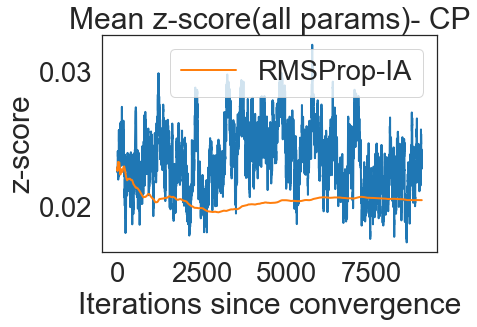

In [29]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,:k] - true_mean_ncp)), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_cp[0][:,:k] - true_mean_ncp)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score(all params)- CP')
plt.legend()

#### Plot for evolution of l2 norm over all sigma parameters

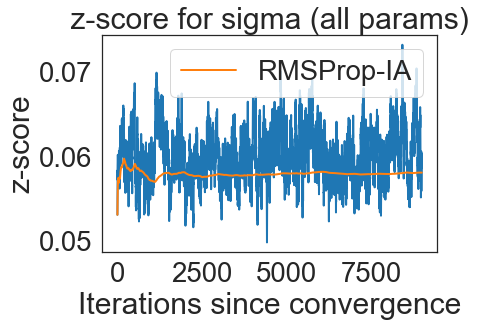

In [31]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,k:] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_cp[0][:,k:] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title(' z-score for sigma (all params) ')
plt.legend()

In [32]:
#### Plot for evolution of l2 norm over all mean parameters

##### We observe high correlation among iterates for group mean parameter - something which is shown in the Rhat plot later... 

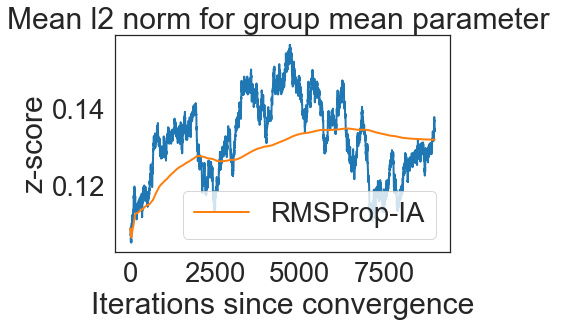

In [33]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,0] - true_mean_ncp[0])))
plt.plot(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_cp[0][:,0] - true_mean_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean l2 norm for group mean parameter ')
plt.legend()




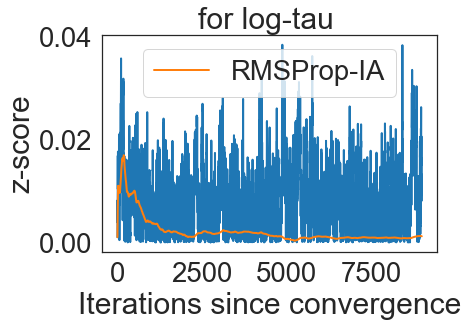

In [48]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,1] - true_mean_ncp[1])))
plt.plot(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_cp[0][:,1] - true_mean_ncp[1])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('for log-tau ')
plt.legend()

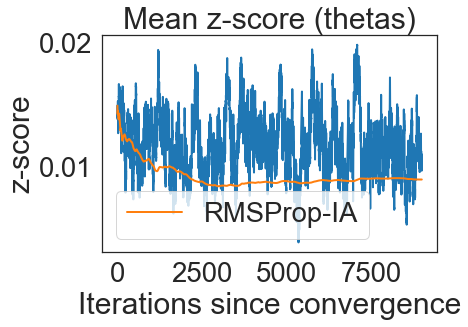

In [49]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,2:k] - true_mean_ncp[2:])), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_cp[0][:,2:k] - true_mean_ncp[2:])), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score (thetas)')
plt.legend()

In [37]:
R_hat_mean_good_cp = op_log_mf_rms_good_cp['r_hat_mean']
R_hat_sigma_good_cp = op_log_mf_rms_good_cp['r_hat_sigma']


#### R hat plot for iterates of mu and log(tau) - window size (500)

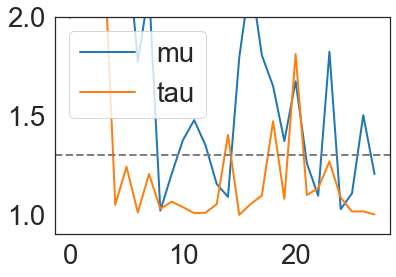

In [53]:
plt.plot(R_hat_mean_good_cp[:,0], label='mu')
plt.plot(R_hat_mean_good_cp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.legend()
#plt.plot(R_hat_mean[:,2:])

#### R hat plot for iterates for thetas using constant ffixed size window of 500

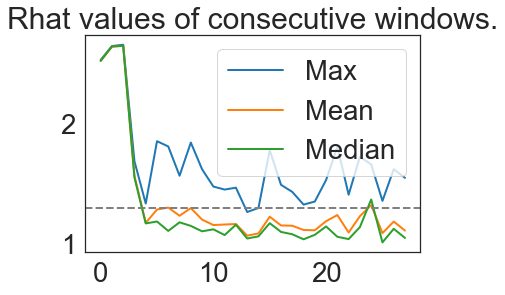

In [54]:
plt.plot(np.max(R_hat_mean_good_cp[:,2:],axis=1), label='Max')
plt.plot(np.mean(R_hat_mean_good_cp[:,2:],axis=1), label='Mean')
plt.plot(np.median(R_hat_mean_good_cp[:,2:],axis=1), label='Median')
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.title('Rhat values of consecutive windows.')
plt.legend()

#### Now, Lets run ADVI with very good initialisation on non-centred parameterisation

In [40]:
klvi_var_param_rms_good_ncp, klvi_var_param_list_rms_good_ncp, avg_klvi_var_param_list_rms_good_ncp, klvi_history_rms_good_ncp, _, op_log_mf_rms_good_ncp = \
    rmsprop_IA_optimize_with_rhat(14000, klvi_mf_objective_and_grad_ncp, good_init_param_cp1, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.50, tail_avg_iters=3000)

Average Loss = -7.66685: 100%|██████████| 14000/14000 [02:01<00:00, 115.05it/s]


In [42]:
print(op_log_mf_rms_good_ncp['start_avg_mean_iters'])
print(op_log_mf_rms_good_ncp['start_avg_sigma_iters'])

11000
4000


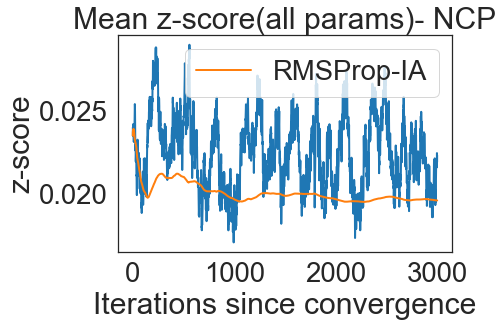

In [44]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,:k] - true_mean_ncp)), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_ncp[0][:,:k] - true_mean_ncp)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score(all params)- NCP')
plt.legend()

####  Averaging seems to be working better here for group mean parameter with non-centered parameterisation .

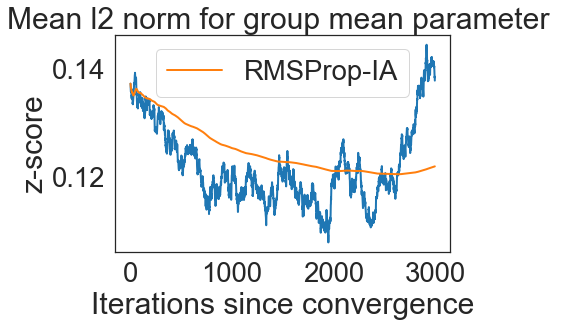

In [47]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,0] - true_mean_ncp[0])))
plt.plot(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_ncp[0][:,0] - true_mean_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean l2 norm for group mean parameter ')
plt.legend()



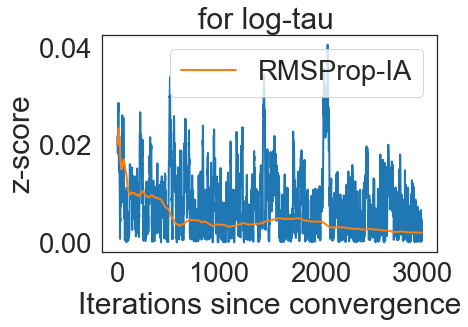

In [50]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,1] - true_mean_ncp[1])))
plt.plot(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_ncp[0][:,1] - true_mean_ncp[1])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('for log-tau ')
plt.legend()

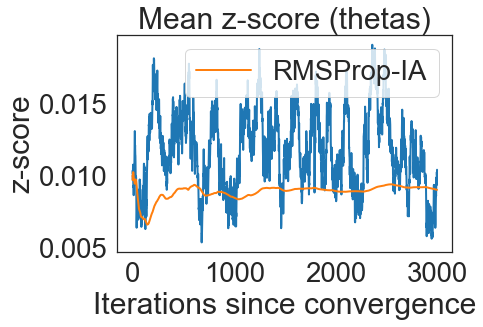

In [51]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,2:k] - true_mean_ncp[2:])), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_good_ncp[0][:,2:k] - true_mean_ncp[2:])), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score (thetas)')
plt.legend()

In [52]:
R_hat_mean_good_ncp = op_log_mf_rms_good_ncp['r_hat_mean']
R_hat_sigma_good_ncp = op_log_mf_rms_good_ncp['r_hat_sigma']

#### The Rhat values for the group parameters are noticeably lower for non-centred parameterisation than the centred one.

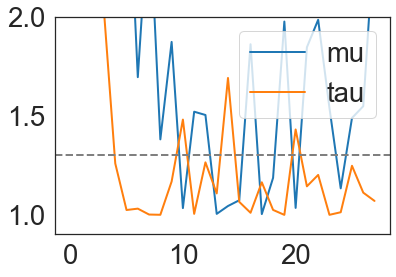

In [55]:
plt.plot(R_hat_mean_good_ncp[:,0], label='mu')
plt.plot(R_hat_mean_good_ncp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.legend()
#plt.plot(R_hat_mean[:,2:])

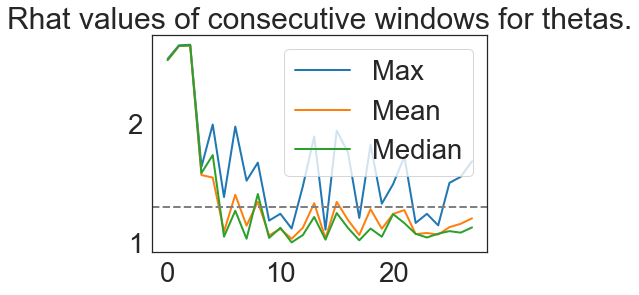

In [57]:
plt.plot(np.max(R_hat_mean_good_ncp[:,2:],axis=1), label='Max')
plt.plot(np.mean(R_hat_mean_good_ncp[:,2:],axis=1), label='Mean')
plt.plot(np.median(R_hat_mean_good_ncp[:,2:],axis=1), label='Median')
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.title('Rhat values of consecutive windows for thetas.')
plt.legend()